In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

df = pd.read_csv('../processed_data/two_digit_NAICS_bds_tfp.csv')

In [6]:
df.columns

Index(['year', 'NAICS', 'firms', 'estabs', 'emp', 'denom', 'estabs_entry',
       'estabs_entry_rate', 'estabs_exit', 'estabs_exit_rate', 'job_creation',
       'job_creation_births', 'job_creation_continuers',
       'job_creation_rate_births', 'job_creation_rate', 'job_destruction',
       'job_destruction_deaths', 'job_destruction_continuers',
       'job_destruction_rate_deaths', 'job_destruction_rate',
       'net_job_creation', 'net_job_creation_rate', 'reallocation_rate',
       'firmdeath_firms', 'firmdeath_estabs', 'firmdeath_emp', 'Industry',
       'Basis', 'weight', 'tfp_pct_change', 'tfp_index_2017',
       'firms_percent_destroyed'],
      dtype='object')

In [7]:
df['tfp_index_2017'] = pd.to_numeric(df['tfp_index_2017'], errors='coerce')
df['tfp_pct_change'] = pd.to_numeric(df['tfp_pct_change'], errors='coerce')

df_plot = (
    df
      .groupby(['NAICS', 'year'])
      .agg({
          'tfp_index_2017': 'mean',
          'tfp_pct_change': 'mean'
      })
      .reset_index()
)

if 'weight' in df.columns:
    # Calculate average weight by NAICS and year
    weights_df = (
        df
        .groupby(['NAICS', 'year'])['weight']
        .mean()
        .reset_index()
    )
    
    df_plot = pd.merge(
        df_plot,
        weights_df,
        on=['NAICS', 'year'],
        how='left'
    )

In [ ]:
fig, ax = plt.subplots(figsize=(12,6), dpi=120)
ax.set_facecolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(which='major', linestyle=':', linewidth=0.7, alpha=0.7)
ax.set_axisbelow(True)

cmap = plt.get_cmap('tab20')

naics_codes = df_plot['NAICS'].unique()
for i, code in enumerate(naics_codes):
    sub = df_plot[df_plot['NAICS'] == code]
    ax.plot(
        sub['year'],
        sub['tfp_index_2017'],
        label=str(code),
        color=cmap(i % 20),
        linewidth=1.2,
        alpha=0.7,
        marker='o',
        markersize=4
    )

ax.set_xticks(range(df_plot['year'].min(), df_plot['year'].max()+1, 5))
ax.set_yticks(range(80, 141, 10))
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Index (2017 = 100)', fontsize=12)

ax.legend(
    title='NAICS',
    bbox_to_anchor=(1.02,1),
    loc='upper left',
    fontsize=8,
    frameon=False
)

plt.tight_layout()
plt.show()

In [11]:
df_plot.head(5)

,NAICS,year,tfp_index_2017,tfp_pct_change,weight
0,11,1987,68.776,NaN,0.009333
1,11,1988,63.369,-7.9,0.008802
2,11,1989,66.843,5.5,0.008845
3,11,1990,70.492,5.5,0.008622
4,11,1991,71.025,0.8,0.008256


In [13]:
aggregate_tfp = (
    df_plot
    .dropna(subset=['tfp_index_2017', 'weight'])
    .groupby('year')
    .apply(lambda x: np.average(x['tfp_index_2017'], weights=x['weight']))
    .reset_index()
    .rename(columns={0: 'weighted_tfp'})
)

C:\Users\Lamb\AppData\Local\Temp\ipykernel_14372\1867904498.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.average(x['tfp_index_2017'], weights=x['weight']))


In [15]:
aggregate_tfp.head(5)

,year,weighted_tfp
0,1987,88.469078
1,1988,88.536818
2,1989,88.653566
3,1990,88.904343
4,1991,88.697883


In [ ]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=120)
ax.set_facecolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(which='major', linestyle=':', linewidth=0.7, alpha=0.7)
ax.set_axisbelow(True)

naics_codes = df_plot['NAICS'].unique()
for code in naics_codes:
    sub = df_plot[df_plot['NAICS'] == code]
    ax.plot(
        sub['year'],
        sub['tfp_index_2017'],
        color='grey',
        linewidth=0.8,
        alpha=0.3,
        marker='',  
    )

ax.plot(
    aggregate_tfp['year'],
    aggregate_tfp['weighted_tfp'],
    label='Weighted Aggregate TFP',
    color='#1f77b4', 
    linewidth=3.0,    
    alpha=1.0,
    marker='o',
    markersize=6,   
    zorder=10        
)

ax.set_xticks(range(df_plot['year'].min(), df_plot['year'].max()+1, 5))

y_min = np.floor(min(df_plot['tfp_index_2017'].min(), aggregate_tfp['weighted_tfp'].min()) / 10) * 10
y_max = np.ceil(max(df_plot['tfp_index_2017'].max(), aggregate_tfp['weighted_tfp'].max()) / 10) * 10
ax.set_yticks(range(int(y_min), int(y_max)+1, 10))

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Total Factor Productivity (2017 = 100)', fontsize=12)
ax.set_title('Weighted Aggregate TFP Trend', fontsize=14)

os.makedirs('../figures', exist_ok=True)  
plt.tight_layout()
plt.savefig('../figures/weighted_tfp_trends.png', dpi=300, bbox_inches='tight')
plt.show()

In [1]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=120)
ax.set_facecolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('axes', 0.0))

ax.grid(which='major', axis='y', linestyle=':', linewidth=0.7, alpha=0.7)
ax.margins(x=0)
ax.set_axisbelow(True)

df_plot_clean = df_plot.dropna(subset=['tfp_index_2017'])
aggregate_tfp_clean = aggregate_tfp.dropna(subset=['weighted_tfp'])

years = aggregate_tfp_clean['year'].values
tfp_values = aggregate_tfp_clean['weighted_tfp'].values

ax.plot(
    years,
    tfp_values,
    color='#1f77b4',  # Blue
    linewidth=3.0,
    alpha=1.0,
    zorder=10
)

if len(years) > 0:  
    historical_start = tfp_values[0] 
    historical_values = []
    
    for year in range(int(years.min()), int(years.max())+1):
        years_from_start = year - years.min()
        historical_values.append(historical_start * (1 + 1.3/100) ** years_from_start)
    
    year_range = range(int(years.min()), int(years.max())+1)
    
    ax.plot(
        year_range, 
        historical_values, 
        '--', 
        linewidth=2.5, 
        color='#ff7f0e',  # Orange
        zorder=5
    )

    # shade in
    interp_actual = np.interp(year_range, years, tfp_values)
    ax.fill_between(
        year_range,
        interp_actual,
        historical_values,
        where=[hv > tv for hv, tv in zip(historical_values, interp_actual)],
        color='#ff7f0e',
        alpha=0.15
    )

if len(years) > 0:
    ax.set_xticks(range(int(years.min()), int(years.max())+1, 5))
    
    all_values = np.concatenate([tfp_values, historical_values])
    y_min = np.floor(min(all_values) / 10) * 10
    y_max = np.ceil(max(all_values) / 10) * 10
    ax.set_yticks(range(int(y_min), int(y_max)+1, 10))

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Total Factor Productivity (index: 2017 = 100)', fontsize=12)

os.makedirs('../figures', exist_ok=True)
plt.tight_layout()
plt.savefig('../figures/tfp_productivity_slowdown.png', dpi=300, bbox_inches='tight')
plt.show()

NameError: name 'plt' is not defined

Bar chart of weighted average TFP percent change by year.

In [12]:
def plot_weighted_tfp_by_year(df):
    df = df.copy()
    
    # Convert columns to numeric, replacing non-numeric values with NaN
    df['tfp_pct_change'] = pd.to_numeric(df['tfp_pct_change'], errors='coerce')
    df['weight'] = pd.to_numeric(df['weight'], errors='coerce')
    
    # Drop rows with NaN in these columns
    df = df.dropna(subset=['tfp_pct_change', 'weight'])
    
    # Calculate weighted average manually by year
    yearly_data = []
    for year in sorted(df['year'].unique()):
        year_data = df[df['year'] == year]
        
        # Manual weighted average calculation
        weighted_sum = (year_data['tfp_pct_change'] * year_data['weight']).sum()
        weight_sum = year_data['weight'].sum()
        
        if weight_sum > 0:  # Avoid division by zero
            weighted_avg = weighted_sum / weight_sum
            yearly_data.append({'year': year, 'weighted_tfp_change': weighted_avg})
    
    yearly_tfp = pd.DataFrame(yearly_data)
    
    # Print the data we'll be plotting
    print("Data to be plotted:")
    print(yearly_tfp)
    
    # Create the plot with adequate figure size
    plt.figure(figsize=(14, 7))
    
    # Get x positions - use integers for bar positions
    x_pos = list(range(len(yearly_tfp)))
    
    # Create the bars using integer positions (no multiplication by 100)
    bars = plt.bar(x_pos, yearly_tfp['weighted_tfp_change'])
    
    # Color the bars based on positive/negative values
    for i, bar in enumerate(bars):
        if yearly_tfp['weighted_tfp_change'].iloc[i] < 0:
            bar.set_color('tomato')
        else:
            bar.set_color('mediumseagreen')
    
    # Add a horizontal line at y=0
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Add labels and title
    plt.title('Weighted Average TFP Percent Change by Year', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('TFP Percent Change (%)', fontsize=12)
    
    # Format y-axis labels with percentage sign
    from matplotlib.ticker import FuncFormatter
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}%'))
    
    # Add grid lines for readability
    plt.grid(axis='y', alpha=0.3)
    
    # Set x-ticks to be at the bar positions, but labeled with years
    plt.xticks(x_pos, yearly_tfp['year'].astype(str), rotation=45)
    
    # Add data labels with adjusted positioning
    for i, v in enumerate(yearly_tfp['weighted_tfp_change']):
        # Adjust vertical offset based on value
        offset = 0.1 if v >= 0 else -0.2
        plt.text(i, v + offset, f'{v:.2f}%', ha='center', fontsize=9)
    
    # Adjust layout with specific margins
    plt.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9)
    
    # Show the plot
    plt.show()
    
    return yearly_tfp

# Example usage:
# yearly_tfp = plot_weighted_tfp_by_year(df)
    
    # Adjust layout with specific margins
    plt.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9)
    
    # Show the plot
    plt.show()
    
    return yearly_tfp
    
    # Create the plot with adequate figure size
    plt.figure(figsize=(12, 6))
    
    # Get x positions
    x_pos = range(len(yearly_tfp))
    
    # Create the bars using x positions
    bars = plt.bar(x_pos, yearly_tfp['weighted_tfp_change'] * 100)
    
    # Color the bars based on positive/negative values
    for i, bar in enumerate(bars):
        if yearly_tfp['weighted_tfp_change'].iloc[i] < 0:
            bar.set_color('red')
        else:
            bar.set_color('green')
    
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Add labels and title
    plt.title('Weighted Average TFP Percent Change by Year')
    plt.xlabel('Year')
    plt.ylabel('TFP Percent Change')
    
    # Format y-axis as percentage
    plt.gca().yaxis.set_major_formatter(PercentFormatter(100))
    
    # Add grid lines for readability
    plt.grid(axis='y', alpha=0.3)
    
    # Set x-ticks to be the years
    plt.xticks(x_pos, yearly_tfp['year'].astype(str), rotation=45)
    
    # Add data labels with adjusted positioning
    for i, v in enumerate(yearly_tfp['weighted_tfp_change']):
        offset = 0.5 if v >= 0 else -1.5
        plt.text(i, v * 100 + offset, 
                 f'{v*100:.2f}%', 
                 ha='center', fontsize=9)
    
    # Add padding around the plot
    plt.gcf().subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9)
    
    # Show the plot
    plt.show()
    
    return yearly_tfp

# Example usage:
yearly_tfp = plot_weighted_tfp_by_year(df)

NameError: name 'df' is not defined

In [5]:
!pip install plotly
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

Data to be plotted:
    year  weighted_tfp_change
0   1988             0.228830
1   1989             0.212520
2   1990             0.246616
3   1991            -0.227970
4   1992             1.822523
5   1993            -0.257658
6   1994             0.447023
7   1995            -0.090773
8   1996             0.861642
9   1997             0.872058
10  1998             0.240650
11  1999             0.862551
12  2000             0.628931
13  2001            -0.454634
14  2002             1.850541
15  2003             1.430500
16  2004             1.482630
17  2005             0.512292
18  2006             0.142916
19  2007             0.163018
20  2008            -0.411440
21  2009             0.006729
22  2010             1.874251
23  2011            -0.178486
24  2012             0.379813
25  2013             0.121657
26  2014             0.644240
27  2015             0.442893
28  2016            -0.286120
29  2017             0.376780
30  2018             0.216447
31  2019            

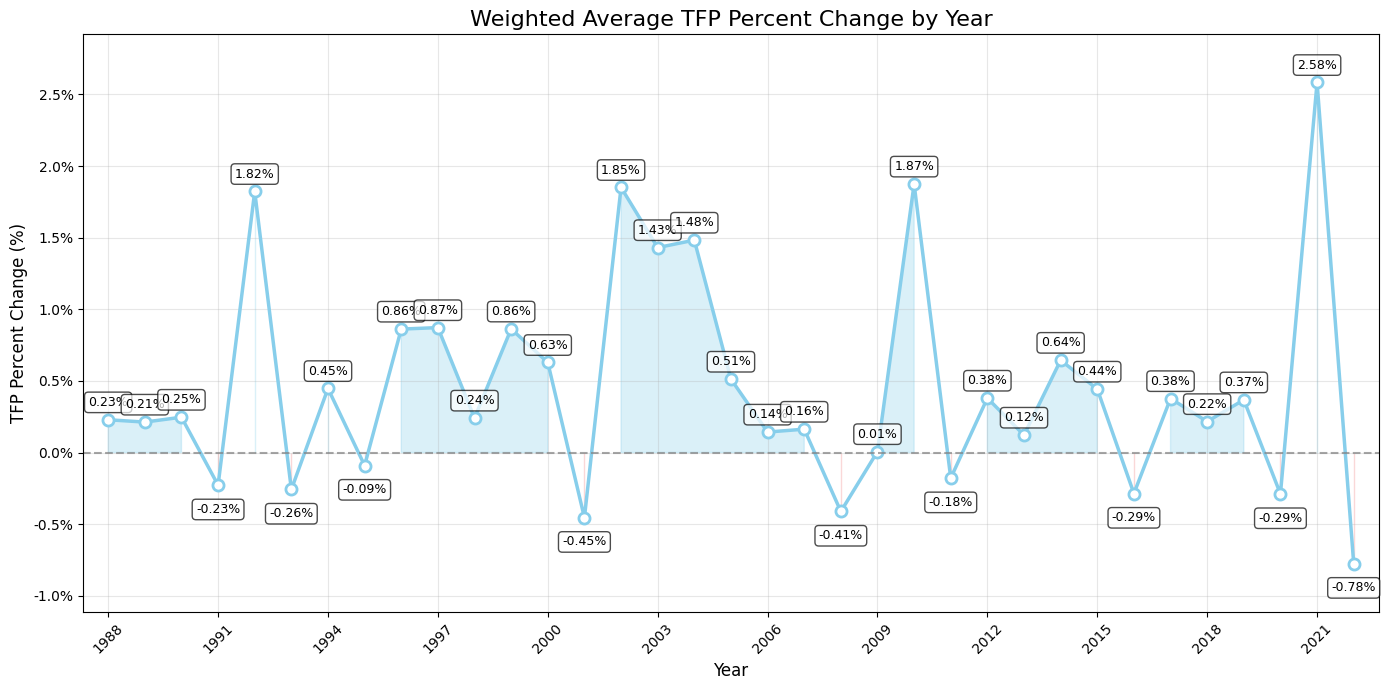

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def plot_weighted_tfp_line(df):
    """
    Create a line plot of weighted average TFP percent change by year.
    Values in tfp_pct_change are already in percentage form.
    """
    # Make a copy to avoid modifying the original
    df = df.copy()
    
    # Convert columns to numeric, replacing non-numeric values with NaN
    df['tfp_pct_change'] = pd.to_numeric(df['tfp_pct_change'], errors='coerce')
    df['weight'] = pd.to_numeric(df['weight'], errors='coerce')
    
    # Drop rows with NaN in these columns
    df = df.dropna(subset=['tfp_pct_change', 'weight'])
    
    # Calculate weighted average manually by year
    yearly_data = []
    for year in sorted(df['year'].unique()):
        year_data = df[df['year'] == year]
        
        # Manual weighted average calculation
        weighted_sum = (year_data['tfp_pct_change'] * year_data['weight']).sum()
        weight_sum = year_data['weight'].sum()
        
        if weight_sum > 0:  # Avoid division by zero
            weighted_avg = weighted_sum / weight_sum
            yearly_data.append({'year': year, 'weighted_tfp_change': weighted_avg})
    
    yearly_tfp = pd.DataFrame(yearly_data)
    
    # Print the data we'll be plotting
    print("Data to be plotted:")
    print(yearly_tfp)
    
    # Create the plot with adequate figure size
    plt.figure(figsize=(14, 7))
    
    # Create a light blue line plot with markers
    plt.plot(
        yearly_tfp['year'], 
        yearly_tfp['weighted_tfp_change'],
        marker='o',                # Add circle markers at each data point
        linestyle='-',            # Solid line
        linewidth=2.5,            # Slightly thicker line
        color='skyblue',          # Light blue color
        markerfacecolor='white',  # White fill for markers
        markeredgecolor='skyblue', # Light blue edge for markers
        markeredgewidth=2,        # Slightly thicker marker edge
        markersize=8              # Marker size
    )
    
    # Add a horizontal line at y=0
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
    
    # Fill area between line and y=0 with light colors
    plt.fill_between(
        yearly_tfp['year'],
        yearly_tfp['weighted_tfp_change'],
        0,
        where=(yearly_tfp['weighted_tfp_change'] >= 0),
        color='skyblue',
        alpha=0.3
    )
    plt.fill_between(
        yearly_tfp['year'],
        yearly_tfp['weighted_tfp_change'],
        0,
        where=(yearly_tfp['weighted_tfp_change'] < 0),
        color='lightcoral',
        alpha=0.3
    )
    
    # Add labels and title
    plt.title('Weighted Average TFP Percent Change by Year', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('TFP Percent Change (%)', fontsize=12)
    
    # Format y-axis labels with percentage sign
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}%'))
    
    # Add grid lines for readability
    plt.grid(True, alpha=0.3)
    
    # Set x-axis tick frequency - show fewer years if there are many
    num_years = len(yearly_tfp)
    step = max(1, num_years // 10)  # Show about 10 year labels
    
    plt.xticks(
        yearly_tfp['year'][::step],  # Show every nth year
        yearly_tfp['year'][::step],
        rotation=45
    )
    
    # Add data labels for each point
    for i, row in yearly_tfp.iterrows():
        x = row['year']
        y = row['weighted_tfp_change']
        
        # Position labels above positive values, below negative values
        offset = 0.15 if y >= 0 else -0.25
        
        plt.annotate(
            f'{y:.2f}%',
            (x, y),
            textcoords="offset points", 
            xytext=(0, 10 if y >= 0 else -20),
            ha='center',
            fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7)
        )
    
    # Adjust plot limits to make room for labels
    plt.margins(x=0.02, y=0.1)
    
    # Adjust layout with specific margins
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
    return yearly_tfp

# Example usage:
yearly_tfp = plot_weighted_tfp_line(df)


/var/folders/xw/3fpv2dn948lcf41k_wd6vbxh0000gn/T/ipykernel_59191/621715863.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x['tfp_pct_change'] * x['norm_weight']).sum())  # Changed to tfp_pct_change


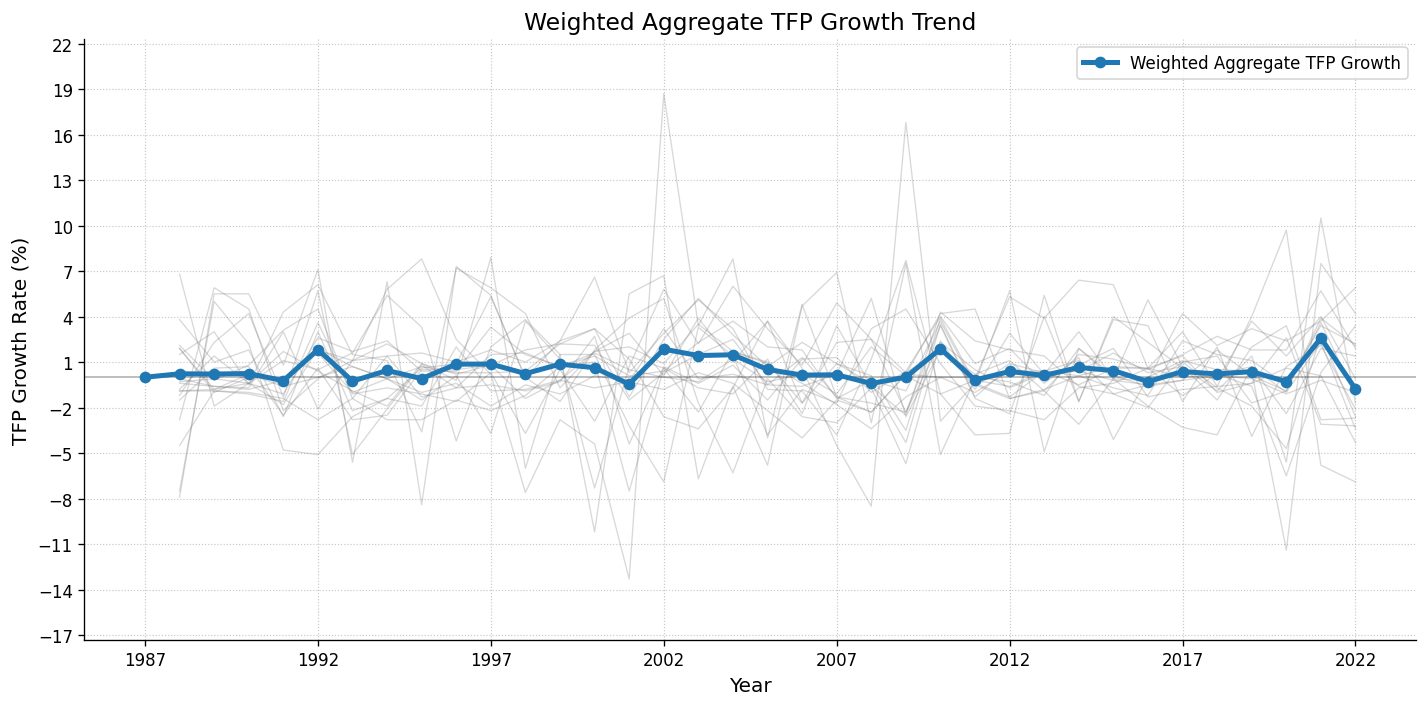

In [6]:
# 4) Set up the figure
fig, ax = plt.subplots(figsize=(12, 6), dpi=120)
ax.set_facecolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(which='major', linestyle=':', linewidth=0.7, alpha=0.7)
ax.set_axisbelow(True)

# 5) Plot all NAICS trends in grey (semi-transparent)
naics_codes = df_plot['NAICS'].unique()
for code in naics_codes:
    sub = df_plot[df_plot['NAICS'] == code]
    ax.plot(
        sub['year'],
        sub['tfp_pct_change'],  # Changed to tfp_pct_change
        color='grey',
        linewidth=0.8,
        alpha=0.3,
        marker='',  # No markers for individual series to reduce clutter
    )

# 6) Plot the weighted aggregate TFP growth in blue (bold)
# First, calculate the weighted aggregate TFP growth
aggregate_growth = df_plot.copy()
if 'weight' in aggregate_growth.columns:
    # Ensure weight is normalized within each year
    aggregate_growth['norm_weight'] = aggregate_growth.groupby('year')['weight'].transform(
        lambda x: x / x.sum()
    )
    
    # Calculate weighted average by year
    weighted_growth = (
        aggregate_growth
        .groupby('year')
        .apply(lambda x: (x['tfp_pct_change'] * x['norm_weight']).sum())  # Changed to tfp_pct_change
        .reset_index(name='weighted_tfp_growth')  # Renamed to weighted_tfp_growth
    )
else:
    # If no weights, just take simple average
    weighted_growth = (
        df_plot
        .groupby('year')['tfp_pct_change']  # Changed to tfp_pct_change
        .mean()
        .reset_index(name='weighted_tfp_growth')  # Renamed to weighted_tfp_growth
    )

# Plot the weighted aggregate growth
ax.plot(
    weighted_growth['year'],
    weighted_growth['weighted_tfp_growth'],
    label='Weighted Aggregate TFP Growth',  # Updated label
    color='#1f77b4',  # Blue
    linewidth=3.0,
    alpha=1.0,
    marker='o',
    markersize=6,
    zorder=10
)

# 7) Ticks & labels
ax.set_xticks(range(df_plot['year'].min(), df_plot['year'].max()+1, 5))

# Dynamic y-ticks based on data range (for percentage changes)
y_min = np.floor(min(df_plot['tfp_pct_change'].min(), weighted_growth['weighted_tfp_growth'].min()))
y_max = np.ceil(max(df_plot['tfp_pct_change'].max(), weighted_growth['weighted_tfp_growth'].max()))
# Add some padding to y-axis
y_padding = (y_max - y_min) * 0.1
y_min -= y_padding
y_max += y_padding
ax.set_ylim(y_min, y_max)

# For percentage changes, we might want different tick spacing
tick_spacing = max(1, int((y_max - y_min) / 10))  # Aim for about 10 ticks
ax.set_yticks(np.arange(int(y_min), int(y_max)+1, tick_spacing))

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('TFP Growth Rate (%)', fontsize=12)  # Updated y-axis label
ax.set_title('Weighted Aggregate TFP Growth Trend', fontsize=14)  # Updated title

# Add horizontal line at y=0 to highlight positive vs negative growth
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)

# Add legend
ax.legend(loc='best', frameon=True, facecolor='white', framealpha=0.8)

# Save with relative path
plt.tight_layout()
plt.savefig('../figures/weighted_tfp_growth_trends.png', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/xw/3fpv2dn948lcf41k_wd6vbxh0000gn/T/ipykernel_59191/2120054060.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  period_avgs = weighted_growth.groupby('period')['weighted_tfp_growth'].mean().reset_index()


AttributeError: 'list' object has no attribute 'tolist'

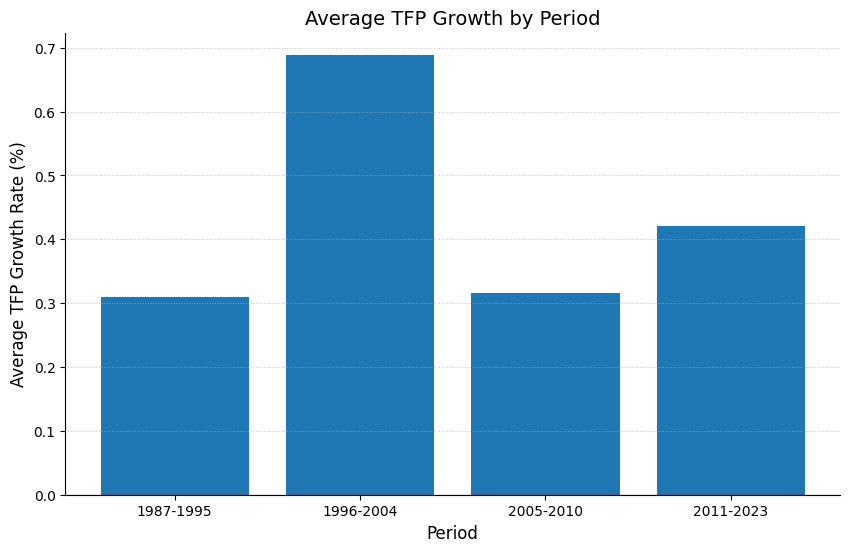

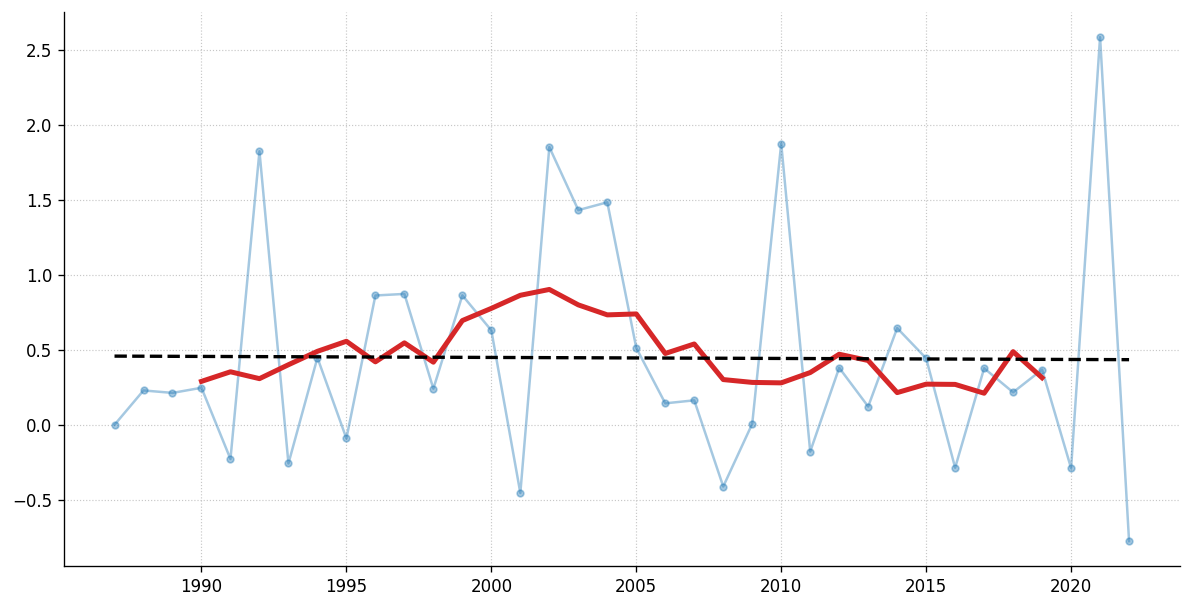